# Convolutional GAN - CelebA Human Faces

Make Your First GAN With PyTorch, 2020

In [5]:
from rich import print
import dill as pickle

## import libraries

In [13]:
import torch
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas as pd
import numpy
import matplotlib.pyplot as plt

## Standard CUDA Check And Set Up

In [7]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce RTX 3080

device(type='cuda')

# Helper Functions

In [8]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [9]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [10]:
# crop (numpy array) image to given width and height

def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

## Dataset Class

In [14]:
class CelebADataset(Dataset):
    """CelebA Dataset class.
    """
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[f'{index}.jpg'])
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2, 0, 1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = np.array(self.dataset[f'{index}.jpg'])
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')

<Figure size 432x288 with 1 Axes>

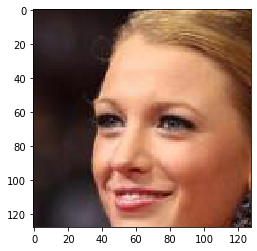

In [15]:
# create Dataset object

celeba_dataset = CelebADataset('celeba_aligned_small.hdf5')

# check data contains images

celeba_dataset.plot_image(21)

## Discriminator Network

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot(**plt_kwargs)

## Test Discriminator

In [17]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))

counter =  1000

counter =  2000

counter =  3000

counter =  4000

counter =  5000

counter =  6000

counter =  7000

counter =  8000

counter =  9000

counter =  10000

counter =  11000

counter =  12000

counter =  13000

counter =  14000

counter =  15000

counter =  16000

counter =  17000

counter =  18000

counter =  19000

counter =  20000

counter =  21000

counter =  22000

counter =  23000

counter =  24000

counter =  25000

counter =  26000

counter =  27000

counter =  28000

counter =  29000

counter =  30000

counter =  31000

counter =  32000

counter =  33000

counter =  34000

counter =  35000

counter =  36000

counter =  37000

counter =  38000

counter =  39000

counter =  40000

CPU times: user 36min 14s, sys: 38min 21s, total: 1h 14min 35s
Wall time: 6min 14s


<Figure size 1152x576 with 1 Axes>

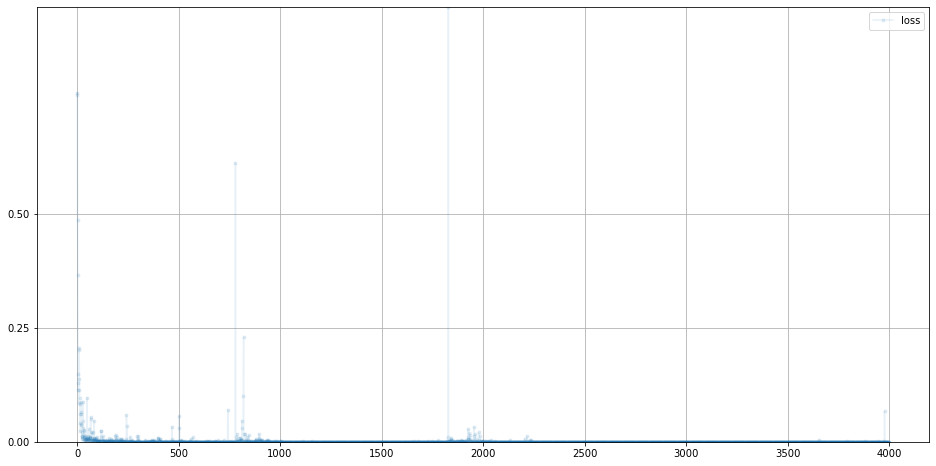

In [18]:
# plot discriminator loss

D.plot_progress()

In [19]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0,20000)]
    print( D.forward( image_data_tensor ).item() )

for i in range(4):
    print( D.forward( generate_random_image((1,3,128,128))).item() )

1.0

1.0

1.0

1.0

1.6165579381777206e-06

1.7437697579225642e-06

2.373947864953152e-07

5.706765023205662e-06

## Generator Network

In [20]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
            
            # reshape to 4d
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            # output should be (1,3,128,128)
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot(**plt_kwargs)

## Test Generator Output

<matplotlib.image.AxesImage object at 0x7f0f30435e80>

<Figure size 432x288 with 1 Axes>

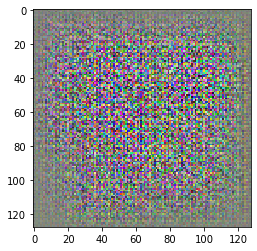

In [21]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [28]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

# epochs = 1
epochs = 8

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

    for image_data_tensor in celeba_dataset:
        # train discriminator on true
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

        # train generator
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch =  1

counter =  1000

counter =  2000

counter =  3000

counter =  4000

counter =  5000

counter =  6000

counter =  7000

counter =  8000

counter =  9000

counter =  10000

counter =  11000

counter =  12000

counter =  13000

counter =  14000

counter =  15000

counter =  16000

counter =  17000

counter =  18000

counter =  19000

counter =  20000

counter =  21000

counter =  22000

counter =  23000

counter =  24000

counter =  25000

counter =  26000

counter =  27000

counter =  28000

counter =  29000

counter =  30000

counter =  31000

counter =  32000

counter =  33000

counter =  34000

counter =  35000

counter =  36000

counter =  37000

counter =  38000

counter =  39000

counter =  40000

epoch =  2

counter =  41000

counter =  42000

counter =  43000

counter =  44000

counter =  45000

counter =  46000

counter =  47000

counter =  48000

counter =  49000

counter =  50000

counter =  51000

counter =  52000

counter =  53000

counter =  54000

counter =  55000

counter =  56000

counter =  57000

counter =  58000

counter =  59000

counter =  60000

counter =  61000

counter =  62000

counter =  63000

counter =  64000

counter =  65000

counter =  66000

counter =  67000

counter =  68000

counter =  69000

counter =  70000

counter =  71000

counter =  72000

counter =  73000

counter =  74000

counter =  75000

counter =  76000

counter =  77000

counter =  78000

counter =  79000

counter =  80000

epoch =  3

counter =  81000

counter =  82000

counter =  83000

counter =  84000

counter =  85000

counter =  86000

counter =  87000

counter =  88000

counter =  89000

counter =  90000

counter =  91000

counter =  92000

counter =  93000

counter =  94000

counter =  95000

counter =  96000

counter =  97000

counter =  98000

counter =  99000

counter =  100000

counter =  101000

counter =  102000

counter =  103000

counter =  104000

counter =  105000

counter =  106000

counter =  107000

counter =  108000

counter =  109000

counter =  110000

counter =  111000

counter =  112000

counter =  113000

counter =  114000

counter =  115000

counter =  116000

counter =  117000

counter =  118000

counter =  119000

counter =  120000

epoch =  4

counter =  121000

counter =  122000

counter =  123000

counter =  124000

counter =  125000

counter =  126000

counter =  127000

counter =  128000

counter =  129000

counter =  130000

counter =  131000

counter =  132000

counter =  133000

counter =  134000

counter =  135000

counter =  136000

counter =  137000

counter =  138000

counter =  139000

counter =  140000

counter =  141000

counter =  142000

counter =  143000

counter =  144000

counter =  145000

counter =  146000

counter =  147000

counter =  148000

counter =  149000

counter =  150000

counter =  151000

counter =  152000

counter =  153000

counter =  154000

counter =  155000

counter =  156000

counter =  157000

counter =  158000

counter =  159000

counter =  160000

epoch =  5

counter =  161000

counter =  162000

counter =  163000

counter =  164000

counter =  165000

counter =  166000

counter =  167000

counter =  168000

counter =  169000

counter =  170000

counter =  171000

counter =  172000

counter =  173000

counter =  174000

counter =  175000

counter =  176000

counter =  177000

counter =  178000

counter =  179000

counter =  180000

counter =  181000

counter =  182000

counter =  183000

counter =  184000

counter =  185000

counter =  186000

counter =  187000

counter =  188000

counter =  189000

counter =  190000

counter =  191000

counter =  192000

counter =  193000

counter =  194000

counter =  195000

counter =  196000

counter =  197000

counter =  198000

counter =  199000

counter =  200000

epoch =  6

counter =  201000

counter =  202000

counter =  203000

counter =  204000

counter =  205000

counter =  206000

counter =  207000

counter =  208000

counter =  209000

counter =  210000

counter =  211000

counter =  212000

counter =  213000

counter =  214000

counter =  215000

counter =  216000

counter =  217000

counter =  218000

counter =  219000

counter =  220000

counter =  221000

counter =  222000

counter =  223000

counter =  224000

counter =  225000

counter =  226000

counter =  227000

counter =  228000

counter =  229000

counter =  230000

counter =  231000

counter =  232000

counter =  233000

counter =  234000

counter =  235000

counter =  236000

counter =  237000

counter =  238000

counter =  239000

counter =  240000

epoch =  7

counter =  241000

counter =  242000

counter =  243000

counter =  244000

counter =  245000

counter =  246000

counter =  247000

counter =  248000

counter =  249000

counter =  250000

counter =  251000

counter =  252000

counter =  253000

counter =  254000

counter =  255000

counter =  256000

counter =  257000

counter =  258000

counter =  259000

counter =  260000

counter =  261000

counter =  262000

counter =  263000

counter =  264000

counter =  265000

counter =  266000

counter =  267000

counter =  268000

counter =  269000

counter =  270000

counter =  271000

counter =  272000

counter =  273000

counter =  274000

counter =  275000

counter =  276000

counter =  277000

counter =  278000

counter =  279000

counter =  280000

epoch =  8

counter =  281000

counter =  282000

counter =  283000

counter =  284000

counter =  285000

counter =  286000

counter =  287000

counter =  288000

counter =  289000

counter =  290000

counter =  291000

counter =  292000

counter =  293000

counter =  294000

counter =  295000

counter =  296000

counter =  297000

counter =  298000

counter =  299000

counter =  300000

counter =  301000

counter =  302000

counter =  303000

counter =  304000

counter =  305000

counter =  306000

counter =  307000

counter =  308000

counter =  309000

counter =  310000

counter =  311000

counter =  312000

counter =  313000

counter =  314000

counter =  315000

counter =  316000

counter =  317000

counter =  318000

counter =  319000

counter =  320000

CPU times: user 11h 9min 27s, sys: 9h 2s, total: 20h 9min 29s
Wall time: 1h 6min 25s


<Figure size 1152x576 with 1 Axes>

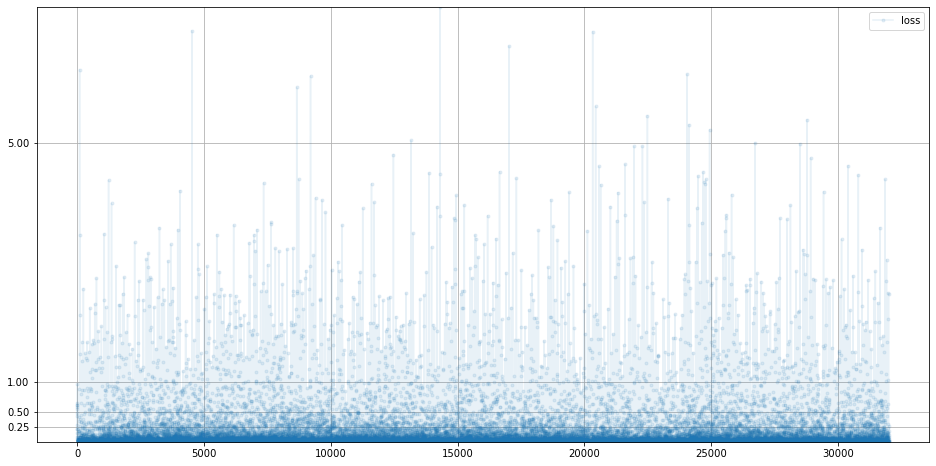

In [29]:
# plot discriminator error

D.plot_progress()

<Figure size 1152x576 with 1 Axes>

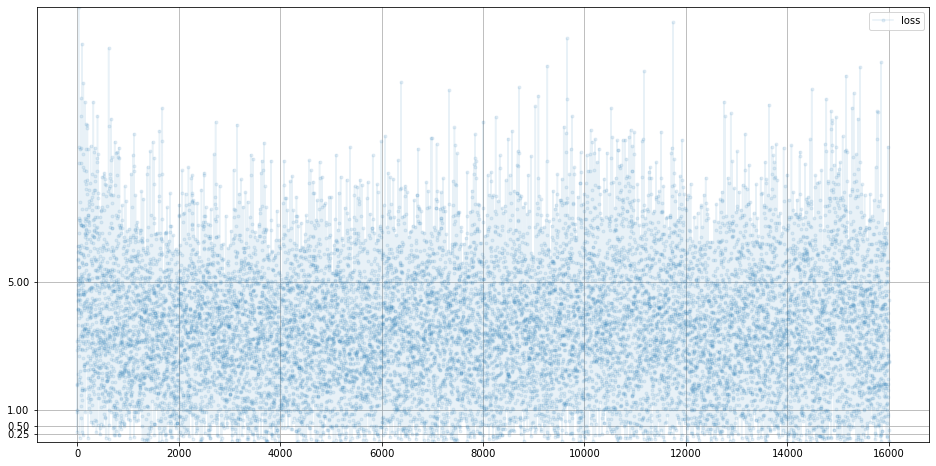

In [30]:
# plot generator error

G.plot_progress()

## Run Generator

<Figure size 1152x576 with 6 Axes>

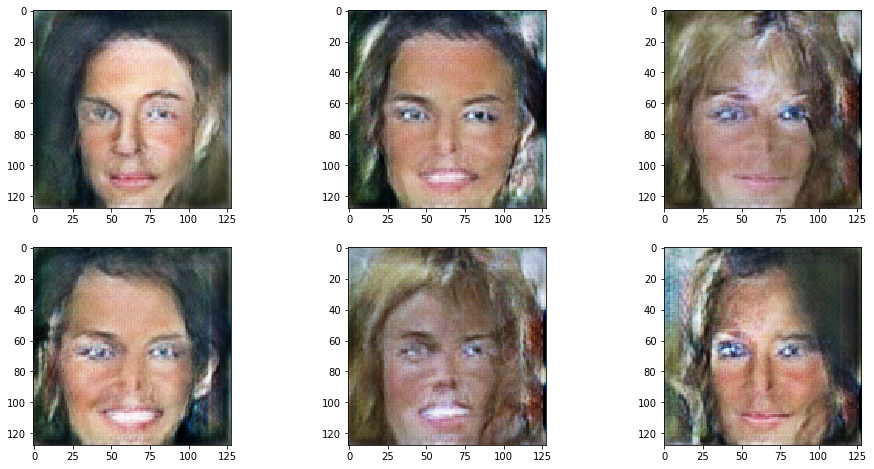

In [41]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

# Memory Consumption

In [43]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.14258766174316406

In [44]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.23886680603027344

## pickle and save the trained GAN

In [45]:
gan = dict(discriminator=D, generator=G)

with open('gan_cnn_celeba.pkl', 'wb') as f:
    pickle.dump(gan, f)

In [46]:
with open('gan_cnn_celeba.pkl', 'rb') as f:
    gan = pickle.load(f)

<Figure size 1152x576 with 6 Axes>

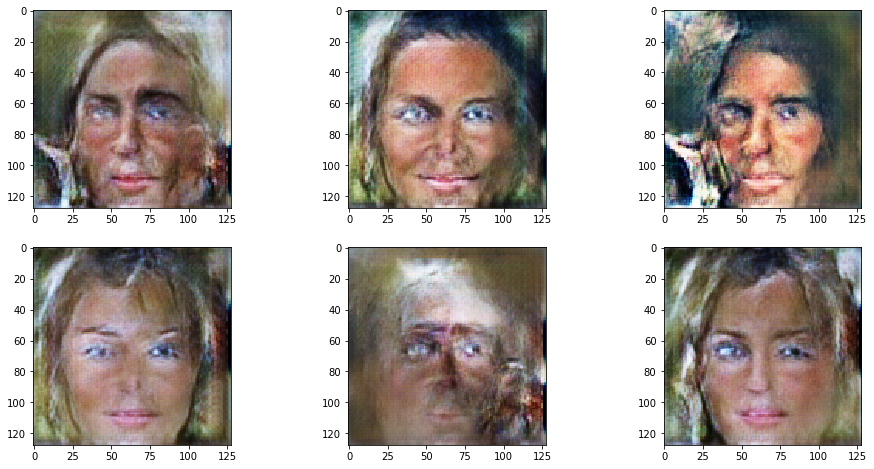

In [50]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = gan['generator'].forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')